# Model 1: CNNs-without-Aug

## 13-Layer CNN Without Data Augmentation

**Architecture:** 13 layers total
- Conv2D(16) → MaxPool → Conv2D(32) → MaxPool → Dropout(0.25)
- Conv2D(64) → MaxPool → Dropout(0.20) → Flatten
- Dense(128) → Dense(64) → Dense(2, Softmax)

**Hyperparameters (from Paper 2):**
- Input: 224×224×3
- Epochs: 100
- Batch size: 30
- Learning rate: 0.0001
- Optimizer: Adam
- Loss: binary_crossentropy
- NO data augmentation

**Target Performance:** 99.22% accuracy

In [4]:
# Load utilities
%run 00_utils_and_config.ipynb

PyTorch version: 2.9.1+cu130
CUDA available: True
CUDA version: 13.0
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Device: cuda
Configuration loaded successfully!

Base path: C:\Users\rishi\CV_Assignment\Paper2
Raw data path: C:\Users\rishi\CV_Assignment\Paper2\Raw_Data
Number of models: 5
Data processing functions loaded successfully!
Evaluation metrics functions loaded successfully!
Visualization functions loaded successfully!
Data augmentation setup loaded successfully!

PAPER 2 UTILITIES AND CONFIGURATION - SUMMARY

✓ All libraries imported successfully
✓ Configuration parameters loaded
✓ Data processing functions defined
✓ Evaluation metrics functions defined
✓ Visualization functions defined
✓ Data augmentation configured

Ready to proceed with:
  - Notebook 01: Data Preparation
  - Notebooks 02-06: Model Implementations
  - Notebook 07: Results Comparison



## 1. Load Preprocessed Data

In [5]:
# Load 224x224 data using memory-mapped dataset (memory efficient)
data_path = CONFIG['processed_data_path']

print("Loading preprocessed data using memory mapping (memory efficient)...")

# Use memory-mapped dataset instead of loading all data into RAM
train_dataset = MemoryMappedDataset(
    X_path=data_path / 'X_train_224.npy',
    y_path=data_path / 'y_train.npy',
    normalize=True
)

test_dataset = MemoryMappedDataset(
    X_path=data_path / 'X_test_224.npy',
    y_path=data_path / 'y_test.npy',
    normalize=True
)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Test:  {len(test_dataset)} samples")

# Create DataLoaders
batch_size = CONFIG['models']['cnn_without_aug']['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\n✓ Memory-mapped DataLoaders created (batch_size={batch_size})")
print("✓ Data is loaded on-the-fly, not stored in RAM")

Loading preprocessed data using memory mapping (memory efficient)...

Dataset sizes:
  Train: 4374 samples
  Test:  1094 samples

✓ Memory-mapped DataLoaders created (batch_size=30)
✓ Data is loaded on-the-fly, not stored in RAM


## 2. Build Model Architecture

In [6]:
# Get model config
model_config = CONFIG['models']['cnn_without_aug']

class CNNWithoutAug(nn.Module):
    """
    13-layer CNN architecture exactly as specified in Paper 2.
    
    Architecture:
    - Input (3, 224, 224)
    - Conv2D(16, 3×3, ReLU) → MaxPooling2D(2×2)
    - Conv2D(32, 3×3, ReLU) → MaxPooling2D(2×2) → Dropout(0.25)
    - Conv2D(64, 3×3, ReLU) → MaxPooling2D(2×2) → Dropout(0.20)
    - Flatten
    - Dense(128, ReLU) → Dense(64, ReLU)
    - Dense(2, Softmax)
    """
    
    def __init__(self, input_channels=3, num_classes=2):
        super(CNNWithoutAug, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.20)
        
        # Calculate flattened size after convolutions
        # Input: 224x224 -> conv1+pool1: 112x112 -> conv2+pool2: 56x56 -> conv3+pool3: 28x28
        self.flatten_size = 64 * 28 * 28
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # First convolutional block
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        # Second convolutional block
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout1(x)
        
        # Third convolutional block
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout2(x)
        
        # Flatten
        x = x.view(-1, self.flatten_size)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Build model
model = CNNWithoutAug(input_channels=3, num_classes=2).to(device)

# Display architecture
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

CNNWithoutAug(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

Total parameters: 6,454,626
Trainable parameters: 6,454,626


In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=model_config['learning_rate'])

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7
)

print(f"\n✓ Model setup complete:")
print(f"  Optimizer: Adam (lr={model_config['learning_rate']})")
print(f"  Loss: CrossEntropyLoss")
print(f"  Scheduler: ReduceLROnPlateau")
print(f"  Device: {device}")


✓ Model setup complete:
  Optimizer: Adam (lr=0.0001)
  Loss: CrossEntropyLoss
  Scheduler: ReduceLROnPlateau
  Device: cuda


## 3. Train Model

In [8]:
# Training helper functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

print(f"Training Model 1: CNNs-without-Aug")
print(f"Epochs: {model_config['epochs']}")
print(f"Batch size: {model_config['batch_size']}")
print(f"Target accuracy: {model_config['target_accuracy']*100:.2f}%\n")

Training Model 1: CNNs-without-Aug
Epochs: 100
Batch size: 30
Target accuracy: 99.22%



In [9]:
# Train model and track time
start_time = time.time()

# Split train data for validation (80% train, 20% val)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader_split = DataLoader(train_subset, batch_size=model_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_subset, batch_size=model_config['batch_size'], shuffle=False)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_model_path = str(CONFIG['saved_models_path'] / 'model1_cnn_without_aug_best.pth')

# Training loop
for epoch in range(model_config['epochs']):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader_split, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch+1}/{model_config['epochs']} - "
              f"Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} - Best model saved")
    elif (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{model_config['epochs']} - "
              f"Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

training_time = time.time() - start_time

print(f"\n✓ Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")

Epoch 1/100 - Loss: 0.6898, Acc: 0.5462, Val Loss: 0.6891, Val Acc: 0.5566 - Best model saved
Epoch 2/100 - Loss: 0.6769, Acc: 0.5782, Val Loss: 0.6659, Val Acc: 0.6354 - Best model saved
Epoch 3/100 - Loss: 0.6411, Acc: 0.6439, Val Loss: 0.6248, Val Acc: 0.6697 - Best model saved
Epoch 5/100 - Loss: 0.5662, Acc: 0.7219, Val Loss: 0.5549, Val Acc: 0.7291 - Best model saved
Epoch 6/100 - Loss: 0.5244, Acc: 0.7479, Val Loss: 0.5212, Val Acc: 0.7326 - Best model saved
Epoch 7/100 - Loss: 0.4972, Acc: 0.7608, Val Loss: 0.4936, Val Acc: 0.7634 - Best model saved
Epoch 9/100 - Loss: 0.4419, Acc: 0.7965, Val Loss: 0.4363, Val Acc: 0.8023 - Best model saved
Epoch 10/100 - Loss: 0.4225, Acc: 0.8011, Val Loss: 0.4696, Val Acc: 0.7714
Epoch 12/100 - Loss: 0.3450, Acc: 0.8460, Val Loss: 0.3501, Val Acc: 0.8400 - Best model saved
Epoch 13/100 - Loss: 0.3255, Acc: 0.8605, Val Loss: 0.3477, Val Acc: 0.8446 - Best model saved
Epoch 14/100 - Loss: 0.2833, Acc: 0.8814, Val Loss: 0.3267, Val Acc: 0.8594 

## 4. Visualize Training History

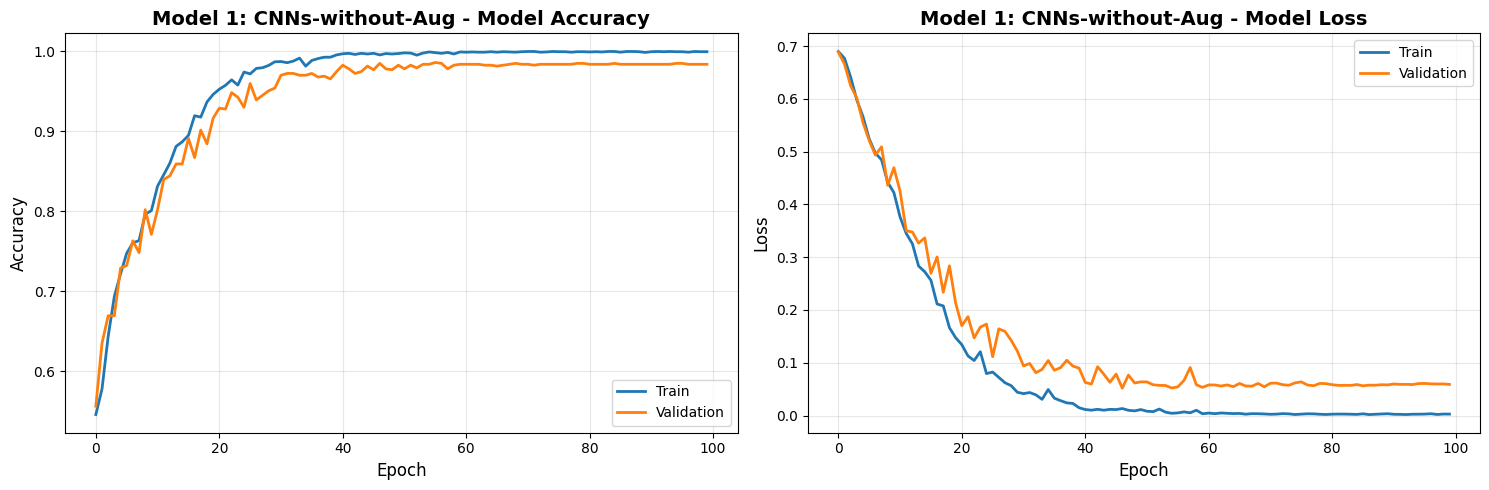

In [14]:
# Plot training curves
plot_training_history(
    history, 
    model_name="Model 1: CNNs-without-Aug",
    save_path=CONFIG['results_path'] / 'training_curves' / 'model1_training_curves.png'
)

## 5. Evaluate on Test Set

In [15]:
# Load best model
best_model = CNNWithoutAug(input_channels=3, num_classes=2).to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

print("Loaded best model from training")

Loaded best model from training


In [16]:
# Make predictions and track time
start_time = time.time()

all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        probs = F.softmax(outputs, dim=1)
        
        all_probs.append(probs.cpu().numpy())
        _, predicted = torch.max(outputs.data, 1)
        all_preds.append(predicted.cpu().numpy())

y_pred_proba = np.vstack(all_probs)
y_pred = np.concatenate(all_preds)

testing_time = (time.time() - start_time) * 1000  # Convert to milliseconds
testing_time_per_sample = testing_time / len(test_dataset)

print(f"Testing time: {testing_time:.2f} ms total")
print(f"Testing time per sample: {testing_time_per_sample:.4f} ms")

Testing time: 1105.07 ms total
Testing time per sample: 1.0101 ms


In [17]:
# Load y_test for metrics calculation
y_test = test_dataset.labels

# Calculate all metrics
metrics = calculate_all_metrics(y_test, y_pred, y_pred_proba[:, 1])

# Print metrics
print_metrics(metrics, model_name="Model 1: CNNs-without-Aug")

# Add timing information
metrics['training_time_seconds'] = training_time
metrics['testing_time_ms'] = testing_time
metrics['testing_time_per_sample_ms'] = testing_time_per_sample


Model 1: CNNs-without-Aug - Evaluation Metrics
Accuracy:    98.45%
Precision:   98.57%
Recall:      97.96%
F1-Score:    98.26%
Specificity: 98.84%
AUC:         0.9949

Confusion Matrix:
  TN=596, FP=7
  FN=10, TP=481



## 6. Visualize Results

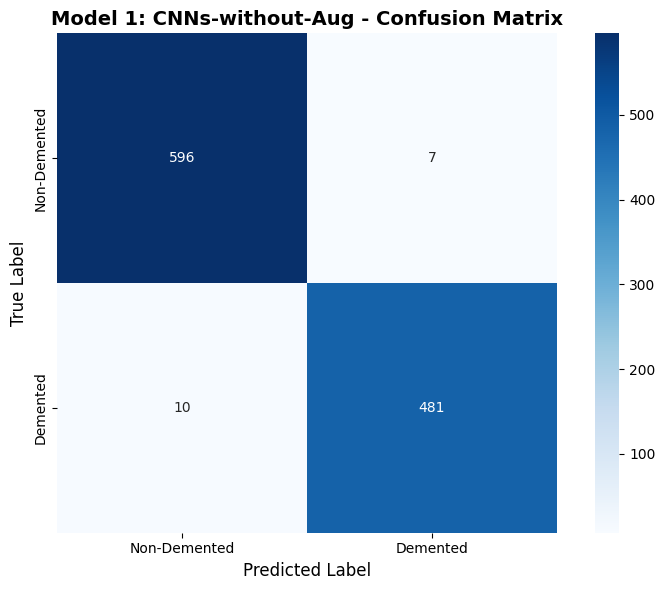

In [18]:
# Confusion matrix
plot_confusion_matrix(
    metrics['confusion_matrix'],
    CONFIG['class_names'],
    title="Model 1: CNNs-without-Aug - Confusion Matrix",
    save_path=CONFIG['results_path'] / 'confusion_matrices' / 'model1_confusion_matrix.png'
)

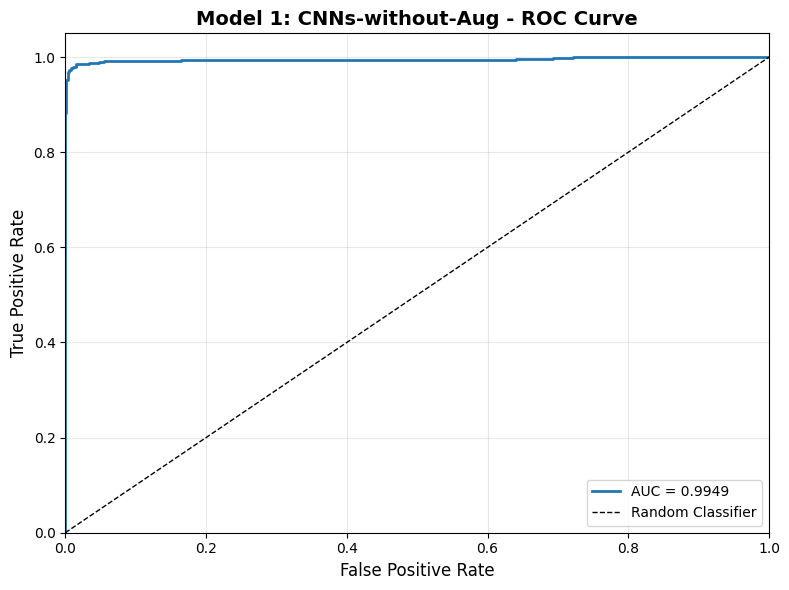

In [19]:
# ROC curve
plot_roc_curve(
    metrics,
    model_name="Model 1: CNNs-without-Aug",
    save_path=CONFIG['results_path'] / 'model1_roc_curve.png'
)

## 7. Save Results

In [ ]:
# Save final model
torch.save(model.state_dict(), CONFIG['saved_models_path'] / 'model1_cnn_without_aug_final.pth')

# Save metrics
results = {
    'model_name': 'CNNs-without-Aug',
    'accuracy': float(metrics['accuracy']),
    'precision': float(metrics['precision']),
    'recall': float(metrics['recall']),
    'f1_score': float(metrics['f1_score']),
    'specificity': float(metrics['specificity']),
    'auc': float(metrics.get('auc', 0)),
    'training_time_seconds': float(training_time),
    'testing_time_ms': float(testing_time),
    'confusion_matrix': metrics['confusion_matrix'].tolist(),
    'hyperparameters': model_config
}

with open(CONFIG['results_path'] / 'model1_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n✓ Model and results saved")


✓ Model and results saved


: 

## 8. Summary

In [ ]:
print("\n" + "="*80)
print("MODEL 1: CNNs-without-Aug - FINAL SUMMARY")
print("="*80)
print(f"\nArchitecture: 13-layer CNN (PyTorch)")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Target parameters (Paper 2): {model_config['total_params']:,}")
print(f"\nPerformance:")
print(f"  Accuracy:     {metrics['accuracy']*100:.2f}% (Target: {model_config['target_accuracy']*100:.2f}%)")
print(f"  Precision:    {metrics['precision']*100:.2f}%")
print(f"  Recall:       {metrics['recall']*100:.2f}%")
print(f"  F1-Score:     {metrics['f1_score']*100:.2f}%")
print(f"  Specificity:  {metrics['specificity']*100:.2f}%")
print(f"  AUC:          {metrics.get('auc', 0):.4f}")
print(f"\nTiming:")
print(f"  Training time: {training_time:.1f}s (Target: ~224s)")
print(f"  Testing time:  {testing_time:.1f}ms (Target: ~4ms)")
print("\n" + "="*80)